<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>




## **Multimodal Models**
Information in the real world exists in many formats: text, images, videos, sounds, and more. Each of these formats communicates ideas, emotions, or instructions—a form of **language** in its own right. Text conveys meaning through words, while images communicate through colors, shapes, and composition. Multimodal models aim to bridge the gap between these diverse formats, enabling machines to understand and connect information across modalities.

Multimodal models allow us to answer complex questions like: **Can we describe an image in words? Can we find a picture based on a phrase?** These models create a unified understanding by learning representations of data from different formats, enabling them to "translate" between modalities.

**Can the visual language of images be translated into text?** If so, what would a model capable of such a feat look like? 


# **CLIP**
The **Contrastive Language-Image Pre-training (CLIP)** was introduced in the paper [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/pdf/2103.00020) in early 2021. Developed by OpenAI, this model is trained to align the visual features of images with the textual features of descriptions, allowing it to understand both text and images simultaneously. This groundbreaking approach enables tasks like generating captions, finding matching pairs, or even zero-shot classification.



### **How CLIP Works at Inference**
<img src="../images/clip-inference.svg" alt="drawing" width="500"/>

CLIP employs two specialized neural networks to process visual and textual inputs:  
1. A **Vision Transformer (ViT)** extracts visual features from images.  
2. A **causal language model** extracts text features from input descriptions.

Both these features are independently processed and then **projected into a shared latent space** with identical dimensions. This shared space allows for a direct comparison of image and text representations.

The core idea is to compute a **similarity score** between the image and text. This is achieved using the **dot product** of their respective feature vectors in the latent space. A higher dot product indicates greater similarity, meaning the text aligns well with the image.

## Use Cases
### Zero-shot Classification:

Zero-shot classification allows a model to classify images without being explicitly trained on the specific categories. Instead, CLIP relies on its ability to align text and image features. You simply provide the model with a set of text descriptions (labels) and an image, and it predicts the most relevant label by measuring the similarity between the image and each text description.

Let's load a CLIP model and perform a zero-shot classification.

In [2]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch
from svlearn_vlu import config

model_name = config["clip"]["model"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [4]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True).to(device)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
probs

tensor([[0.9949, 0.0051]], grad_fn=<SoftmaxBackward0>)

### Image Retrieval

Image retrieval is the reverse of zero-shot classification. Instead of asking, *"What is this image?"* we ask, *"Which image matches this description?"* The goal is to find the most relevant images from a collection based on a textual query.

In the context of CLIP, we leverage its ability to understand and compare both text and image features in a shared latent space. 

This is particularly useful for tasks like:
- Searching for specific images in a database.
- Organizing image collections by themes.
- Enabling visual search features in applications.



#### Searching for specific backgrounds in Oak tree images.

In this example, we will retrieve images that match our description from a collection of oak tree images. Here's how we'll approach this task:

1. **Image Embedding Extraction**: We've already processed our image dataset to extract embeddings using CLIP and stored in a vector db collection called `"tree_embeddings"` in `svlearn/clip/embed_images.py`.
   
2. **Text Query Embedding**: We'll use CLIP to encode the textual description into a query embedding. The code is provided in `svlearn/clip/query_images.py`

3. **Similarity Computation**: The similarity between the query embedding and each image embedding will be computed in the shared latent space.

4. **Retrieval**: Images with the highest similarity scores will be returned as the most relevant results.


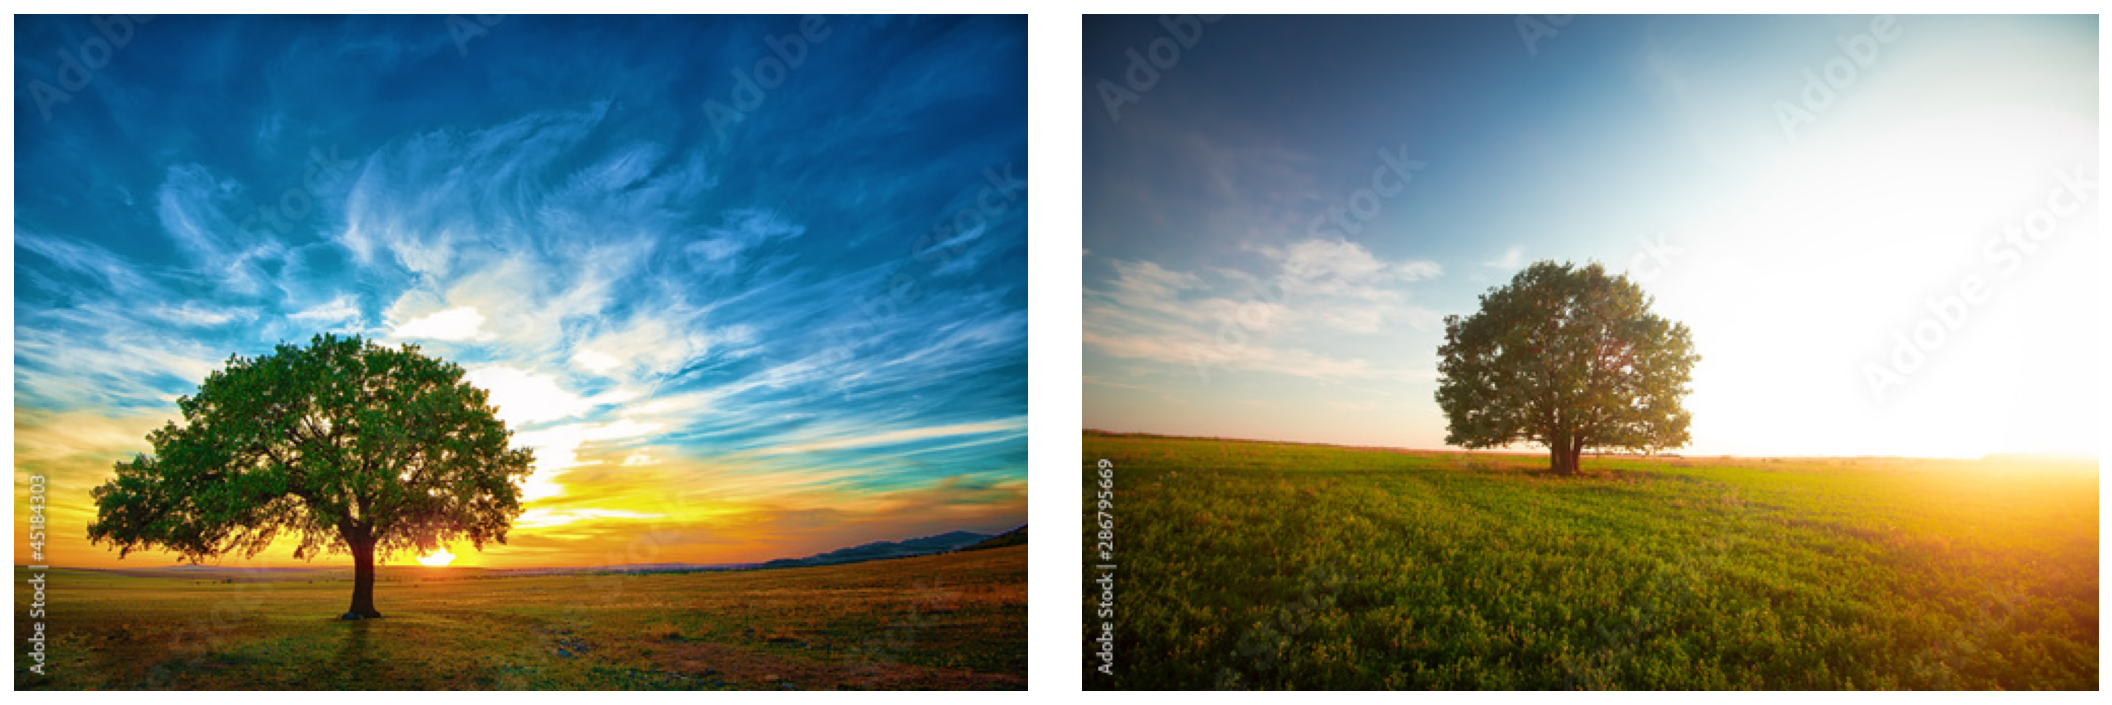

In [5]:
from svlearn_vlu.clip.query_images import search_similar_images, show_images_as_subplots

query = "a photo of a sunset"
results = search_similar_images(query, top_k=2)

show_images_as_subplots(results)


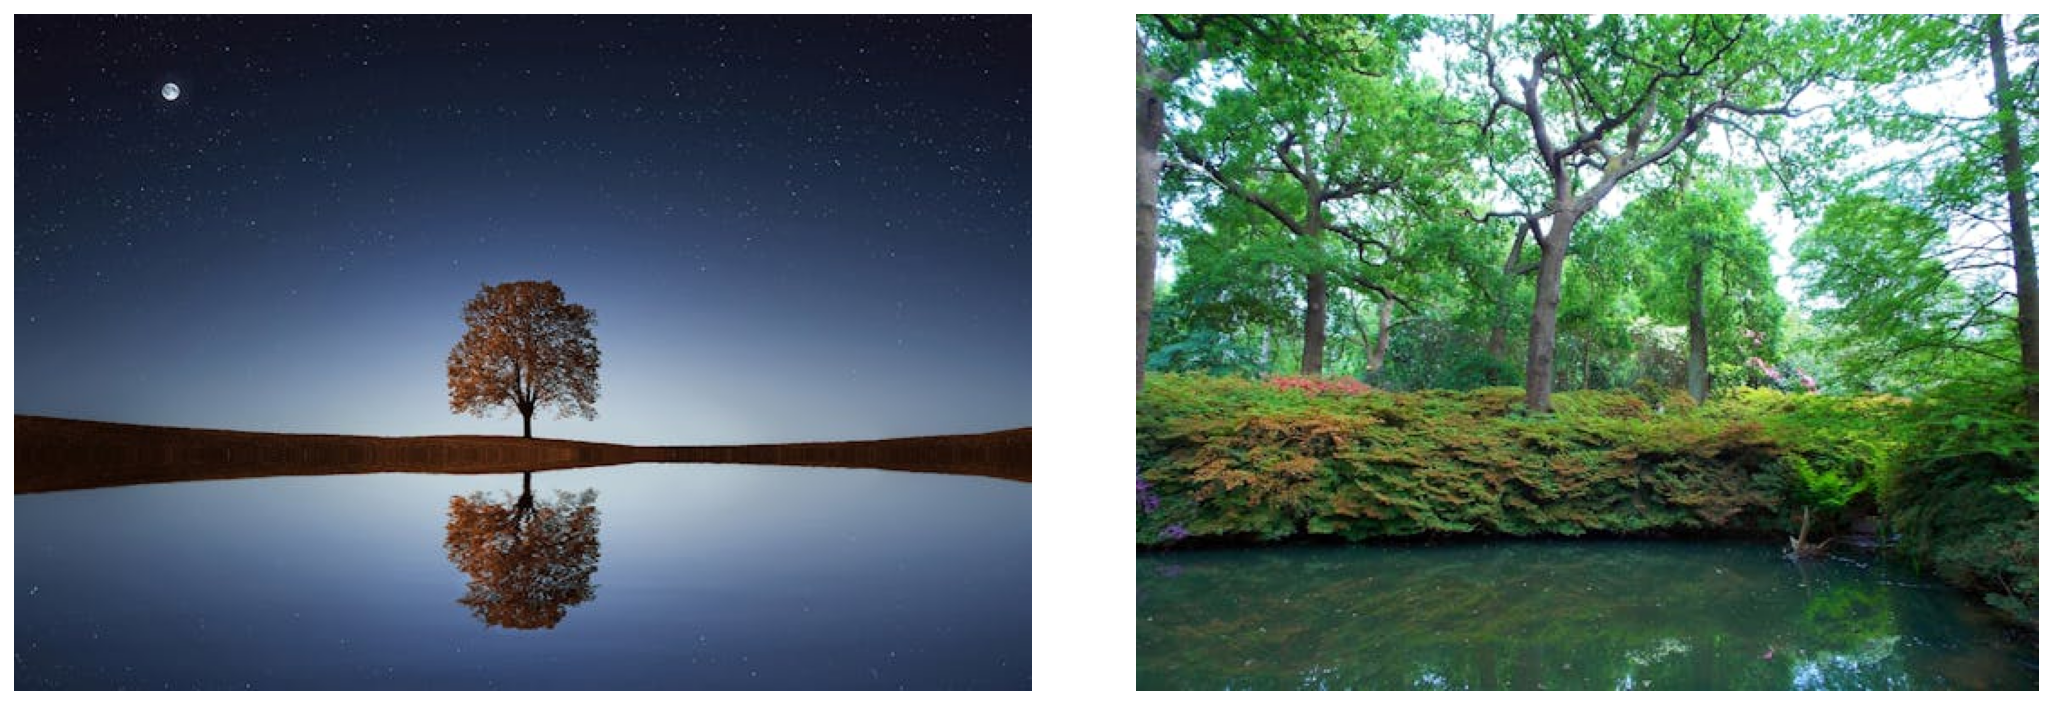

In [6]:
query = "a photo of a lake"
results = search_similar_images(query, top_k=2)

show_images_as_subplots(results)

# for result in results:
#     print(f"Score: {result.score}, Path: {result.payload['path']}")

## How CLIP is pretrained

CLIP is pretrained using a massive dataset of image-text pairs, leveraging the connection between visual and textual modalities. 

During training:
- An image is passed through a Vision Transformer (ViT) to obtain an image embedding.
- A text description is passed through a Transformer-based language model to obtain a text embedding.
- Both embeddings are projected to the same latent space.

The **contrastive loss** works by maximizing the similarity of the correct image-text pair while minimizing the similarity of incorrect pairs. This ensures that the model learns to associate visual features with their corresponding textual meanings effectively. Let's look at it more closely in the following section.

<img src="../images/clip.svg" alt="drawing" width="500"/>

### **Contrastive Learning**

In the paper, the CLIP model is trained with a N-pair loss technique. To understand this, let’s first delve into the concept of **negative sampling**.

#### Negative Sampling
In contrastive learning, we aim to bring embeddings of similar pairs closer together while pushing apart embeddings of dissimilar pairs. A common approach is **negative sampling**, where for a given positive pair (e.g., an image and its matching text), we select one or more "negative" samples (e.g., unrelated images or texts) to define what the model should *not* match. However, this method has some shortcomings:
- **Limited negatives**: Selecting only one or a few negatives per pair can make the optimization less effective.
- **Quality of negatives**: The chosen negatives might not always provide strong contrast, reducing the effectiveness of the training signal.

#### Using the Batch as Negatives
Instead of relying on explicit negative sampling, **Multiclass N-pair loss** leverages the other examples in the training batch as implicit negatives. For a given positive pair, all other embeddings in the batch (e.g., other images or texts) are treated as negatives. This has several advantages:
- **Increased negatives**: The number of negative samples scales with the batch size, providing a richer training signal.
- **Dynamic negatives**: Every batch introduces diverse negatives, improving generalization.

The details of this loss function can be found in equation (6) of [Improved Deep Metric Learning with Multi-class N-pair Loss Objective](https://proceedings.neurips.cc/paper_files/paper/2016/file/6b180037abbebea991d8b1232f8a8ca9-Paper.pdf). 

We will explain this loss function in the context of CLIP in the following section.

### Multiclass N-Pair Loss adopted for CLIP


$$
\mathcal{L}_{\text{img2text}} = -\log \left( \frac{\exp(\text{sim}(f_{\text{img}}, f_{\text{text}}^+))}{\exp(\text{sim}(f_{\text{img}}, f_{\text{text}}^+)) + \sum_{i \neq +} \exp(\text{sim}(f_{\text{img}}, f_{\text{text}}^i))} \right)
$$

This is the **image-to-text alignment loss** . CLIP also uses a symmetric text-to-image loss.  Therefore the total loss is given by:


$$
\mathcal{L}_{\text{CLIP}} = \mathcal{L}_{\text{img2text}}  + \mathcal{L}_{\text{text2img}} 
$$




1. **Embeddings ($ f_{\text{img}} $ and $ f_{\text{text}} $):**
   - $ f_{\text{img}} $: Embedding vector for an image, produced by the vision encoder (e.g., a ViT or ResNet).
   - $ f_{\text{text}} $: Embedding vector for a text, produced by the text encoder (e.g., a Transformer).

2. **Similarity Function ($ \text{sim}(a, b) $):**
   - Typically, CLIP uses the **cosine similarity** between the two embeddings.
   - Cosine similarity ensures alignment in the shared latent space regardless of vector magnitude.

3. **Positive Pair ($ f_{\text{img}}, f_{\text{text}}^+ $):**
   - A positive pair is the matching image and text from the same pair in the batch.

4. **Negative Examples ($ f_{\text{text}}^- $):**
   - Negative examples are all other text embeddings in the batch for the current image embedding.
   - Similarly, in the text-to-image loss, the negatives are all other image embeddings.


#### Negative Log Likelihood (NLL)
 
   The fraction inside the $\log$ represents the probability of the correct text match ($f_{\text{text}}^+$) for a given image embedding ($f_{\text{img}}$):
   $$
   P(f_{\text{text}}^+ \mid f_{\text{img}}) = \frac{\exp(\text{sim}(f_{\text{img}}, f_{\text{text}}^+))}{\exp(\text{sim}(f_{\text{img}}, f_{\text{text}}^+)) + \sum_{i \neq +} \exp(\text{sim}(f_{\text{img}}, f_{\text{text}}^i))}
   $$
   This is a softmax probability, treating the positive match as the "true label" and all other negative samples as alternative classes.

   The negative log likelihood is defined as:
   $$
   \text{NLL} = -\log P(\text{true class})
   $$
   Substituting $P(f_{\text{text}}^+ \mid f_{\text{img}})$ as the probability of the "true class," the loss becomes:
   $$
   \mathcal{L}_{\text{img2text}} = -\log P(f_{\text{text}}^+ \mid f_{\text{img}})
   $$

The equation represents the **negative log likelihood** of the correct text match for an image, where the softmax formulation converts similarity scores into probabilities over all candidate text embeddings. Minimizing it ensures that the model assigns higher similarity to positive pairs and lower similarity to negative pairs.



### Advantages of N-Pair loss in CLIP
- **Scalability:**
  - Using batch-based negatives avoids the need to compute embeddings for all possible examples in the dataset, making the training scalable.
- **Efficient Alignment:**
  - The loss ensures that matching pairs have higher similarity while separating them from mismatched pairs.

By training on a large dataset of diverse image-text pairs, CLIP learns a powerful multimodal embedding space that generalizes well to downstream tasks.

## Shortcomings of the CLIP Model

While CLIP is a groundbreaking model, it has some limitations that should be considered:

1. **Short Captions**:
   - CLIP's training pairs often consist of short, high-level captions, which might miss nuanced details in the images.
   - As a result, the model struggles to grasp fine-grained visual details or specific relationships between objects in complex scenes.

2. **Noisy Training Data**:
   - CLIP is trained on large-scale datasets scraped from the web, which can contain noisy, irrelevant, or incorrect captions.
   - This may lead to biases or misinterpretations in the model’s outputs.

3. **Lack of Fine-Grained Understanding**:
   - CLIP excels at capturing general semantic relationships but is less effective for tasks requiring precise localization or fine-grained classification (e.g., identifying subtle differences between visually similar objects).


**BLIP (Bootstrapped Language-Image Pretraining)**, is a model designed to address some of these challenges. We will explore it in the following notebook.


## References

1. [Improved Deep Metric Learning with Multi-class N-pair Loss Objective](https://proceedings.neurips.cc/paper_files/paper/2016/file/6b180037abbebea991d8b1232f8a8ca9-Paper.pdf)

2. [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/pdf/2103.00020)
